# <b/><font color='green'><center> Fraudlent Transactions Predictions</center></font>

### <b>Task to be done:</b>
Your task is to execute the process for proactive detection of fraud while answering following
questions.
1. Data cleaning including missing values, outliers and multi-collinearity.
2. Describe your fraud detection model in elaboration.
3. How did you select variables to be included in the model?
4. Demonstrate the performance of the model by using best set of tools.
5. What are the key factors that predict fraudulent customer?
6. Do these factors make sense? If yes, How? If not, How not?
7. What kind of prevention should be adopted while company update its infrastructure?
8. Assuming these actions have been implemented, how would you determine if they work?

## <b/> Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import itertools
from collections import Counter

from statsmodels.stats.outliers_influence import variance_inflation_factor

## <b/> Loading the Dataset 

In [8]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## <b/> Data Preprocessing

In [11]:
df.shape

(6362620, 11)

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [15]:
df.duplicated().sum()

0

#### Dataset with no NULL values


## <b/> Exploratory Data Analysis

In [19]:
# Number of fraud and legitimate transactions
fraud = len(df[df['isFraud'] == 1])
legit = len(df[df['isFraud'] == 0])

print("Number of Fraud transactions: ", fraud)
print("Number of Legit transactions: ", legit)

Number of Fraud transactions:  8213
Number of Legit transactions:  6354407


- These results prove that this is a highly unbalanced data as Number of Fraud transactions is 8213 and Number of Legit transactions= 6354407. So Random Forest, Decision Trees, XGBoost are good methods for the highly unbalanced data.

In [22]:
# Visualzing the Merchants Data
X = df[df['nameDest'].str.contains('M')]
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


- There is no information for oldbalanceDest and newbalanceDest for the Merchants.

In [24]:
# checking correlation
corr = df.corr(numeric_only=True)
corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


<Axes: >

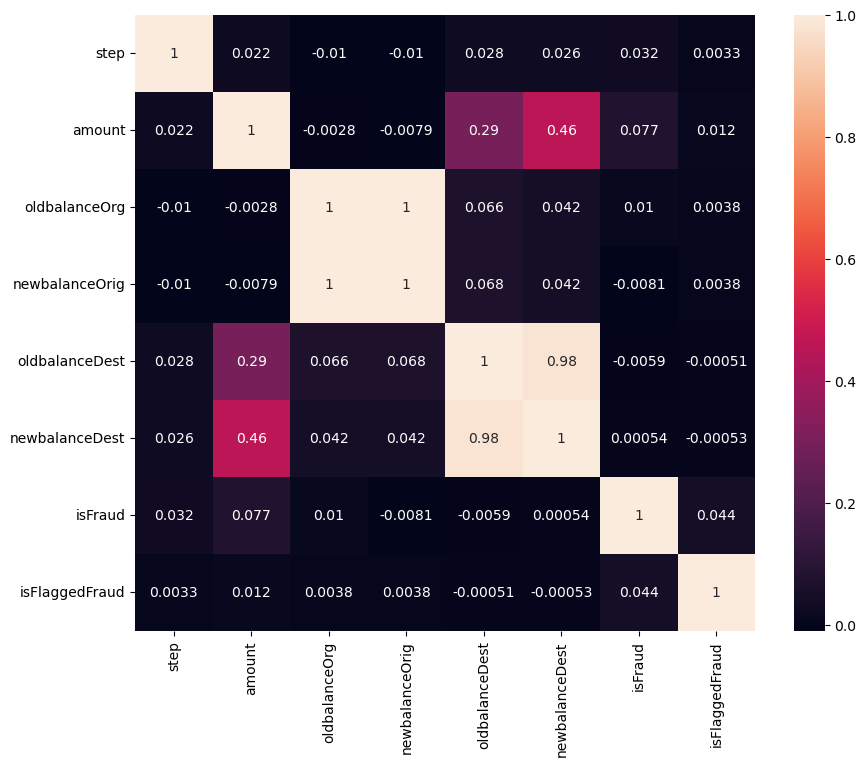

In [25]:
# plotting correlation using heatmap
sns.heatmap(data=corr, annot=True)

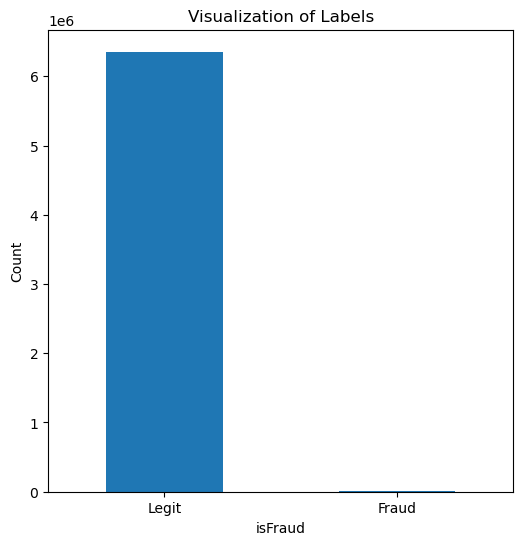

In [26]:
# plotting bar chart for legit & fraud transaction
plt.figure(figsize=(6,6))
labels = ["Legit", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

# <b/> Feature Engineering

In [28]:
# create a copy of the original dataframe
df_new = df.copy()
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## <b/> Label Encoding

In [30]:
# check object datatypes
objList = df_new.select_dtypes(include = "object").columns
print(objList)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


- There are 3 attributes with object datatype. We need to label encode these to check multicollinearity.

In [32]:
# encode the objects
le = LabelEncoder()

for f in objList:
    df_new[f] = le.fit_transform(df_new[f].astype(str))

print(df_new.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int32  
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(3), int64(3)
memory usage: 461.2 MB
None


In [33]:
df_new.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


## <b/> Multicollinearity

In [35]:
# function to find the variation inflation factor
def cal_vif(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(df.shape[1])]
    return vif

cal_vif(df_new)

,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


- We can see that oldbalanceOrg and newbalanceOrig have too high VIF thus they are highly correlated. Similarly oldbalanceDest and newbalanceDest. Also nameDest is connected to nameOrig.

- Thus combine these pairs of collinear attributes and drop the individual ones.

In [37]:
# creating new features to capture the change in balances and transaction paths
df_new['Actual_amount_orig'] = df_new.apply(lambda x: x['oldbalanceOrg'] - x['newbalanceOrig'],axis=1)
df_new['Actual_amount_dest'] = df_new.apply(lambda x: x['oldbalanceDest'] - x['newbalanceDest'],axis=1)
df_new['TransactionPath'] = df_new.apply(lambda x: x['nameOrig'] + x['nameDest'],axis=1)

#Dropping columns
df_new = df_new.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

cal_vif(df_new)

,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,Actual_amount_orig,1.307910
5,Actual_amount_dest,3.754335
6,TransactionPath,2.677167


<Axes: >

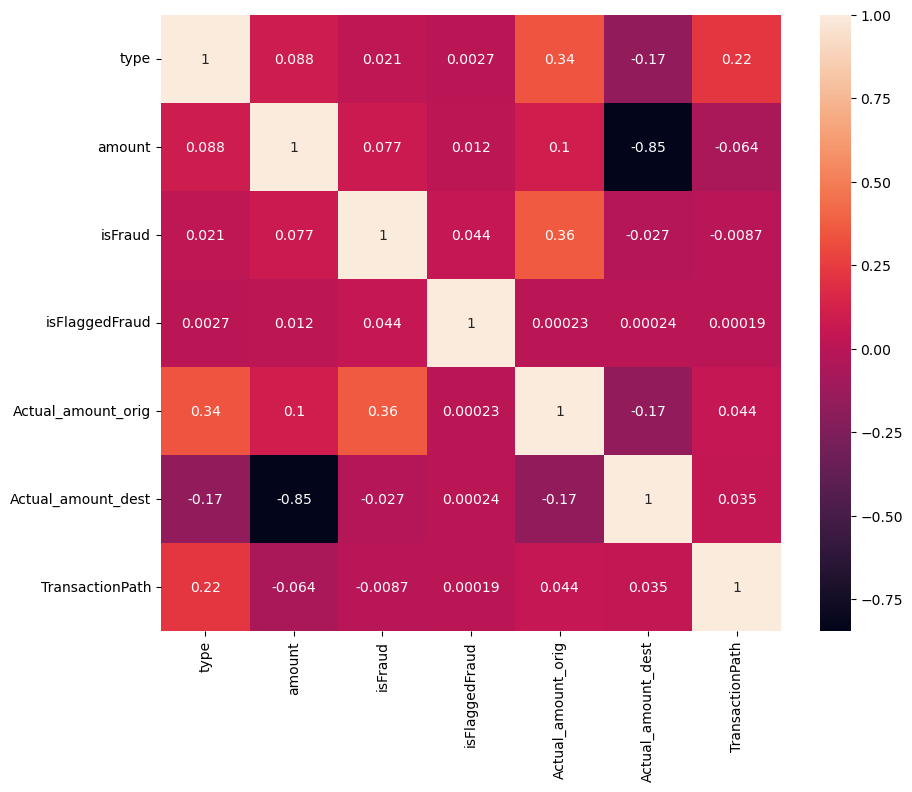

In [38]:
# new correlation heatmap
corr=df_new.corr()

sns.heatmap(corr,annot=True)

<b/> How did you select variables to be included in the model?
   
- Using the VIF values and correlation heatmap. We just need to check if there are any two attributes highly correlated to each other and then drop the one which is less correlated to the isFraud Attribute.

# <b/> ML Model Building

## <b/> Scaling the Data

In [42]:
# scale the dataset
scaler = StandardScaler()
df_new["NormalizedAmount"] = scaler.fit_transform(df_new["amount"].values.reshape(-1, 1))
df_new.drop(["amount"], inplace= True, axis= 1)

Y = df_new["isFraud"]
X = df_new.drop(["isFraud"], axis= 1)

In [43]:
df_new

,type,isFraud,isFlaggedFraud,Actual_amount_orig,Actual_amount_dest,TransactionPath,NormalizedAmount
0,3,0,0,9839.64,0.00,2419963.0,-0.281560
1,3,0,0,1864.28,0.00,3922922.0,-0.294767
2,4,1,0,181.00,0.00,1441841.0,-0.297555
3,1,1,0,181.00,21182.00,6219958.0,-0.297555
4,3,0,0,11668.14,0.00,4274900.0,-0.278532
...,...,...,...,...,...,...,...
6362615,1,1,0,339682.13,-339682.13,6157710.0,0.264665
6362616,4,1,0,6311409.28,0.00,1998227.0,10.153953
6362617,1,1,0,6311409.28,-6311409.27,642182.0,10.153953
6362618,4,1,0,850002.52,0.00,2572645.0,1.109765


In [44]:
# Check the class distribution
fraud_count = df_new['isFraud'].value_counts()
print("Class Distribution:")
print(fraud_count)

Class Distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [45]:
# Separate the majority and minority classes
df_majority = df_new[df_new['isFraud'] == 0]
df_minority = df_new[df_new['isFraud'] == 1]

# Downsample the majority class to match the size of the minority class
df_majority_downsampled = df_majority.sample(len(df_minority), random_state=42)

# Combine the downsampled majority class with the minority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print("Balanced Class Distribution:")
print(df_balanced['isFraud'].value_counts())


Balanced Class Distribution:
isFraud
1    8213
0    8213
Name: count, dtype: int64


In [46]:
Y = df_balanced["isFraud"]
X = df_balanced.drop(["isFraud"], axis= 1)

- I did not normalize the complete dataset because it may lead to decrease in accuracy of model.



## <b/> Splitting the Data

In [50]:
# split the dataset for training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (11498, 6)
Shape of X_test:  (4928, 6)


## <b/> Model Training

In [52]:
# Decision Tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

Y_pred_dt = dtc.predict(X_test)
dtc_score = dtc.score(X_test, Y_test) * 100

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the Sequential model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))

# Second hidden layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))

# Output layer for binary classification (0 for non-fraud, 1 for fraud)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,561 (10.00 KB)

 Trainable params: 2,561 (10.00 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5870 - loss: 177933.2031 - val_accuracy: 0.9004 - val_loss: 129.9032
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6995 - loss: 8071.5044 - val_accuracy: 0.5448 - val_loss: 46.3587
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6789 - loss: 1692.5938 - val_accuracy: 0.9054 - val_loss: 3.6105
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6620 - loss: 767.8298 - val_accuracy: 0.5856 - val_loss: 18.5730
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6550 - loss: 336.1966 - val_accuracy: 0.5264 - val_loss: 21.7308
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6617 - loss: 307.2104 - val_accuracy: 0.6629 - val_loss: 17.6075
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6537 - loss: 201.3349 - val_accuracy: 0.6347 - val_loss: 30.1160
Epoch 8/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6572 - loss:

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers


# Define the VGG16-like model
def create_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # For binary classification
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the model
model = create_model(X_train.shape[1])


In [64]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7818 - loss: 6981.8691 - val_accuracy: 0.8929 - val_loss: 287.4833
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8612 - loss: 510.3966 - val_accuracy: 0.7618 - val_loss: 208.4173
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8573 - loss: 287.3763 - val_accuracy: 0.7746 - val_loss: 81.5833
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8785 - loss: 109.2777 - val_accuracy: 0.9209 - val_loss: 19.8263
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8962 - loss: 35.7151 - val_accuracy: 0.9267 - val_loss: 164.4969
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8626 - loss: 219.2482 - val_accuracy: 0.7411 - val_loss: 114.6095
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8759 - loss: 94.4642 - val_accuracy: 0.8807 - val_loss: 28.9468
Epoch 8/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8802 

154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5408 - loss: 0.6568
Test Accuracy: 54.53%
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Confusion Matrix:
[[2484    0]
 [2241  203]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69      2484
           1       1.00      0.08      0.15      2444

    accuracy                           0.55      4928
   macro avg       0.76      0.54      0.42      4928
weighted avg       0.76      0.55      0.42      4928

ROC-AUC Score: 0.5415302782324058


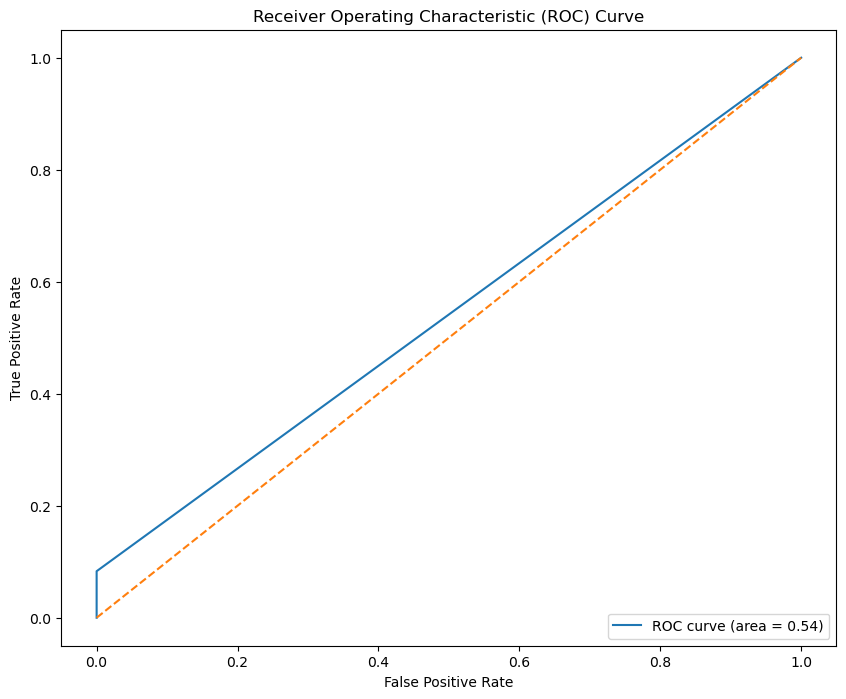

In [65]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict on the test set
Y_pred = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

print("Confusion Matrix:")
print(confusion_matrix(Y_test, Y_pred))
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred))

# Calculate and display ROC-AUC score
roc_auc = roc_auc_score(Y_test, Y_pred)
print(f"ROC-AUC Score: {roc_auc}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [67]:
# Make predictions on the test set
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions


154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [68]:
# Create the confusion matrix
cm = confusion_matrix(Y_test, predictions)

# Optionally normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalized


<Figure size 800x600 with 0 Axes>

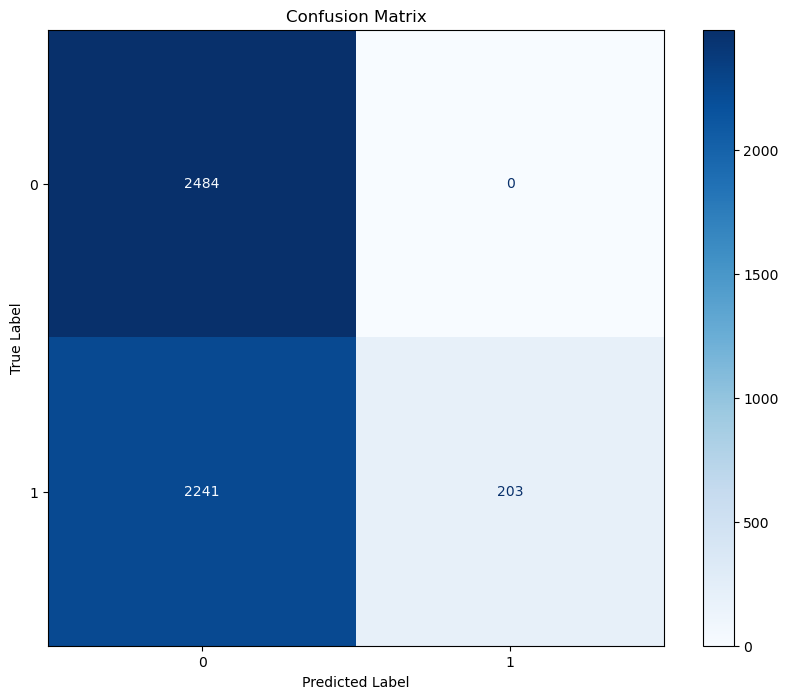

In [69]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

# Optional: Add title and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


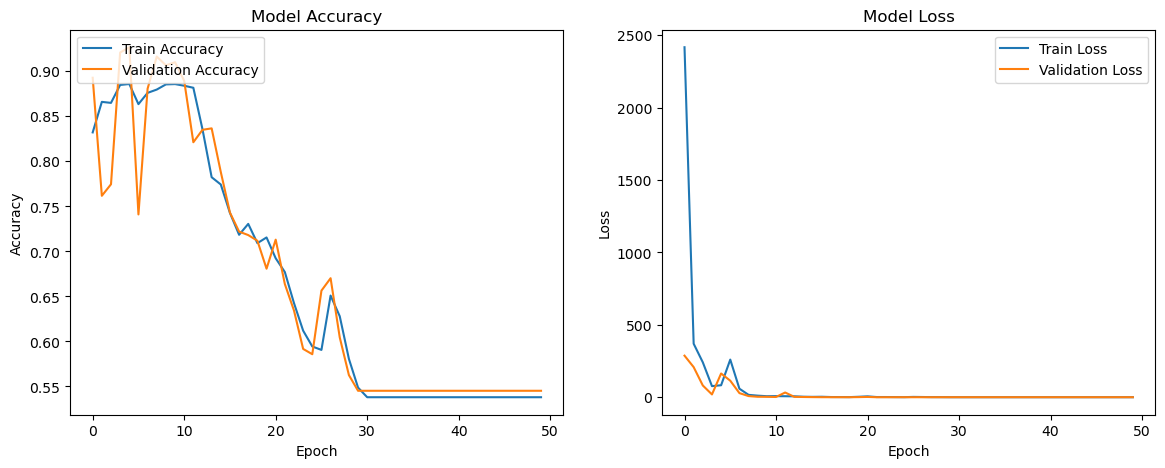

In [70]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Subplot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Subplot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [ ]:
# Decision Tree
dtc = DecisionTreeClassifier()
dtc.fit(X_train, Y_train)

Y_pred_dtc = dtc.predict(X_test)
dtc_score = dtc.score(X_test, Y_test) * 100

In [72]:
# Random Forest
rfc = RandomForestClassifier(n_estimators= 100)
rfc.fit(X_train, Y_train)

Y_pred_rf = rfc.predict(X_test)
rfc_score = rfc.score(X_test, Y_test) * 100

In [73]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)

Y_pred_xgb = xgb.predict(X_test)
xgb_score = xgb.score(X_test, Y_test) * 100

In [74]:
print("Decision Tree Score: ", dtc_score)
print("Random Forest Score: ", rfc_score)
print("XGBoost Score      : ", xgb_score)

Decision Tree Score:  96.1038961038961
Random Forest Score:  96.77353896103897
XGBoost Score      :  97.01704545454545


- XGBoost is better than Decision Tree and Random Forest Classifier.

In [79]:
# classification report - DT

classification_report_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_report_dt)

print("----------------------------------------------------------------------------------------")

# classification report - RF

classification_report_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forest")
print(classification_report_rf)

print("----------------------------------------------------------------------------------------")

# classification report - XGB

classification_report_xgb = classification_report(Y_test, Y_pred_xgb)
print("Classification Report - XGBoost")
print(classification_report_xgb)

Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2484
           1       0.96      0.96      0.96      2444

    accuracy                           0.96      4928
   macro avg       0.96      0.96      0.96      4928
weighted avg       0.96      0.96      0.96      4928

----------------------------------------------------------------------------------------
Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2484
           1       0.96      0.98      0.97      2444

    accuracy                           0.97      4928
   macro avg       0.97      0.97      0.97      4928
weighted avg       0.97      0.97      0.97      4928

----------------------------------------------------------------------------------------
Classification Report - XGBoost
              precision    recall  f1-score   support

     

- With Such a good precision and hence F1-Score, XGBoost comes out to be better as expected.

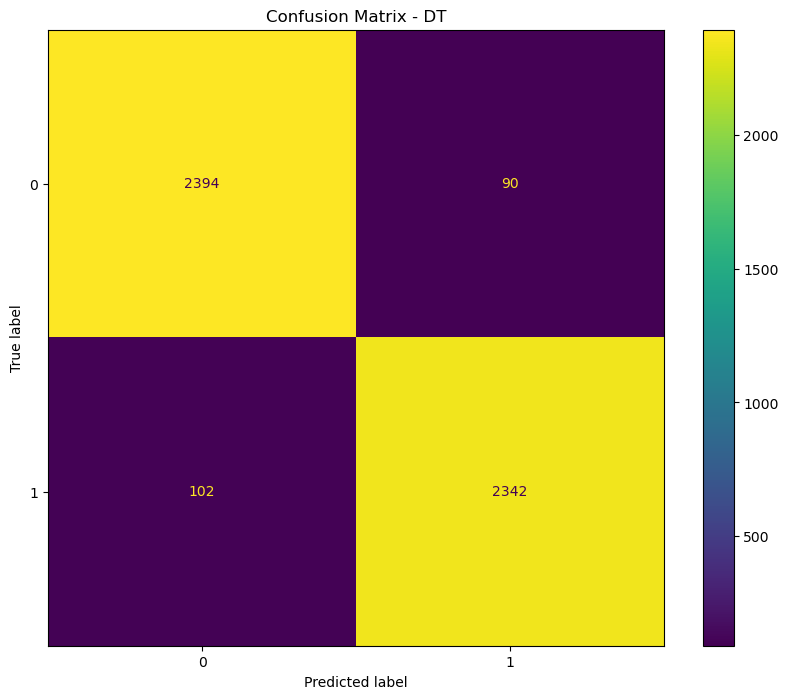

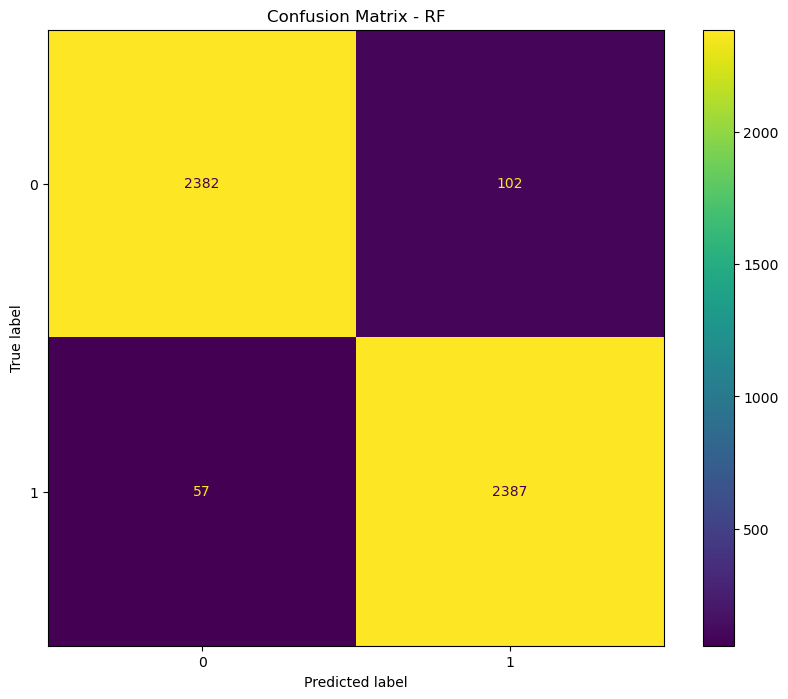

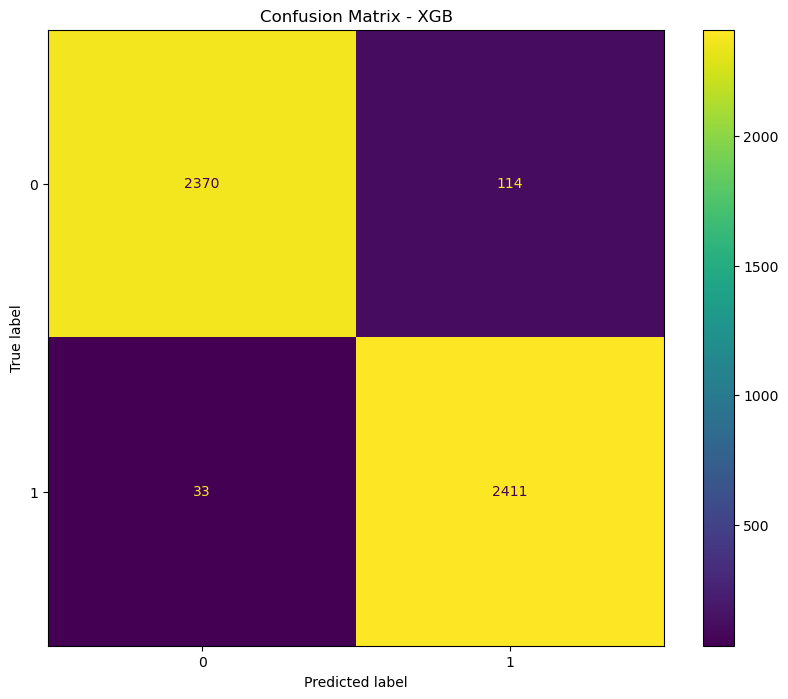

In [81]:
# visualising confusion matrix - DT

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt)
disp.plot()
plt.title('Confusion Matrix - DT')
plt.show()

# visualising confusion matrix - RF
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf)
disp.plot()
plt.title('Confusion Matrix - RF')
plt.show()

# visualising confusion matrix - XGB
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_xgb)
disp.plot()
plt.title('Confusion Matrix - XGB')
plt.show()

## <b/> Conclusion:

<b/> Describe your fraud detection model in elaboration.

The accuracy of Random Forest, Decision Tree, and XGBoost is observed to be comparable, but XGBoost outperforms in terms of precision. Precision is crucial in a fraud detection model because the goal is not just to identify normal transactions correctly but to ensure fraudulent transactions are detected accurately while minimizing the misclassification of legitimate transactions. Failing in either aspect could lead to penalizing innocent individuals or letting fraudsters go unnoticed.

This is one of the key reasons why ensemble methods are preferred over other algorithms.

Additionally, I selected this model due to the highly imbalanced nature of the dataset (Legitimate: Fraudulent = 6,354,407:8,213). XGBoost constructs a predictive model by iteratively combining predictions from multiple base models, often decision trees.

While models like Bagging, ANN, and Logistic Regression may achieve high accuracy, they often fall short in delivering strong precision and recall metrics.

<b/> How did you select variables to be included in the model? 

- Variables are chosen using correlations and VIF scores.

<b/> Demonstrate the performance of the model by using best set of tools.

- The model shows  0.9701704545454545 accuracy on the XGBoost algorithm.

<b/> What are the key factors that predict fraudulent customer?

- Transaction amount.
- Whether the source of payment request is secured or not?
- Transaction type.
- Is the receiver organization is legitimate or not?
- Changes in balances.

<b/> Do These Factors Make Sense? If Yes, How? If Not, How Not?

Yes, these factors make sense:
- Transaction Amount: Large or unusual amounts can indicate fraud.
- Transaction Type: Certain transaction types might be more prone to fraud (e.g., international transfers).
- Balance Changes: Significant changes in balances might signal unauthorized transactions.

<b/> What Kind of Prevention Should Be Adopted While Company Update Its Infrastructure?


- User Behavior Analytics
- Real-Time Monitoring
- Regular Audits
- Multi-Factor Authentication (MFA)
- Data Encryption

<b/> Assuming These Actions Have Been Implemented, How Would You Determine If They Work?

To determine if the actions are effective:

- Monitor Fraud Rates: Track the fraud rates before and after implementation.
- Performance Metrics: Continuously monitor model performance metrics (accuracy, precision, recall, ROC AUC).
- User Feedback: Gather feedback from users on the new security measures.
- Regular Reviews: Conduct regular reviews of security incidents to assess improvements.